Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/input_layer.py:26: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 421.0341
Epoch 2/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.1580
Epoch 3/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.5373
Epoch 4/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4467
Epoch 5/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.3400
Epoch 6/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1936
Epoch 7/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2125
Epoch 8/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1779
Epoch 9/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.2121
Epoch 10/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.2008
Epoch 11/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1332
Epoch 12/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.1182
Epoch 13/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 0.1353
Epoch 14/100
1538/1538 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.1567
Epoch 15/100
1538/1538 ━━

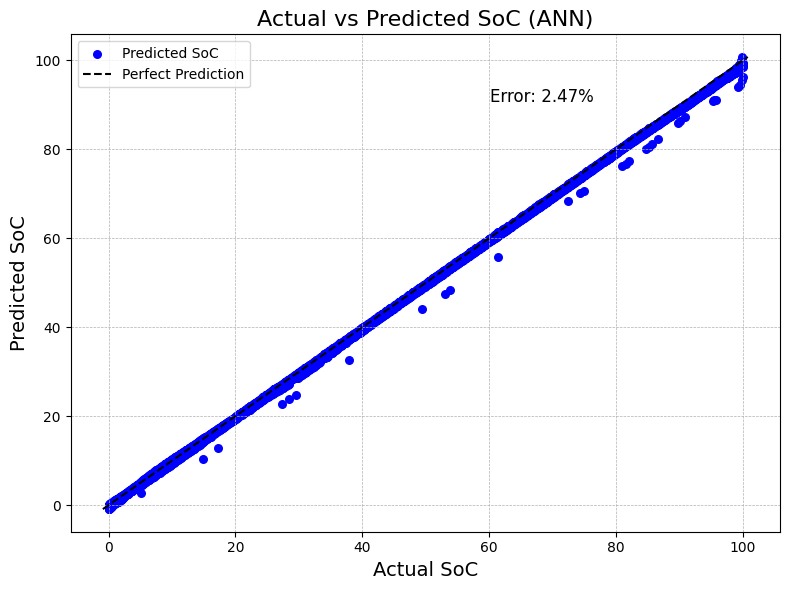

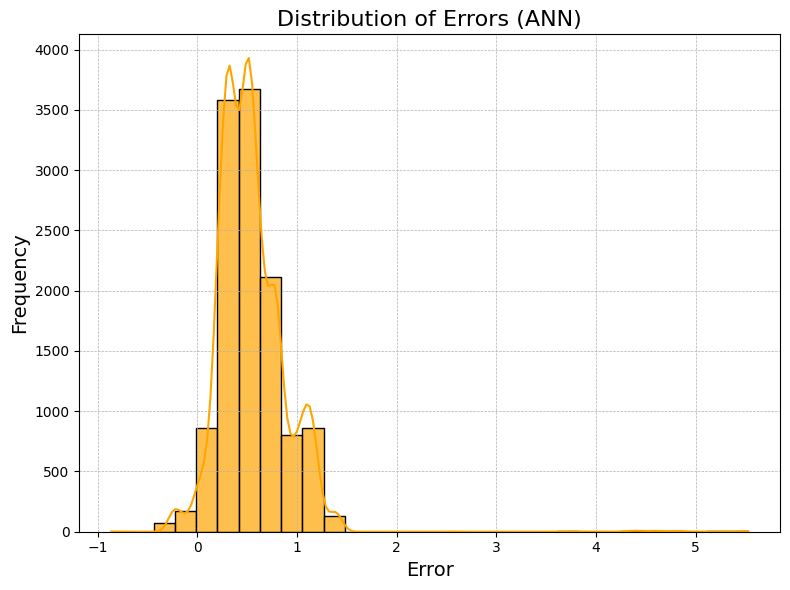

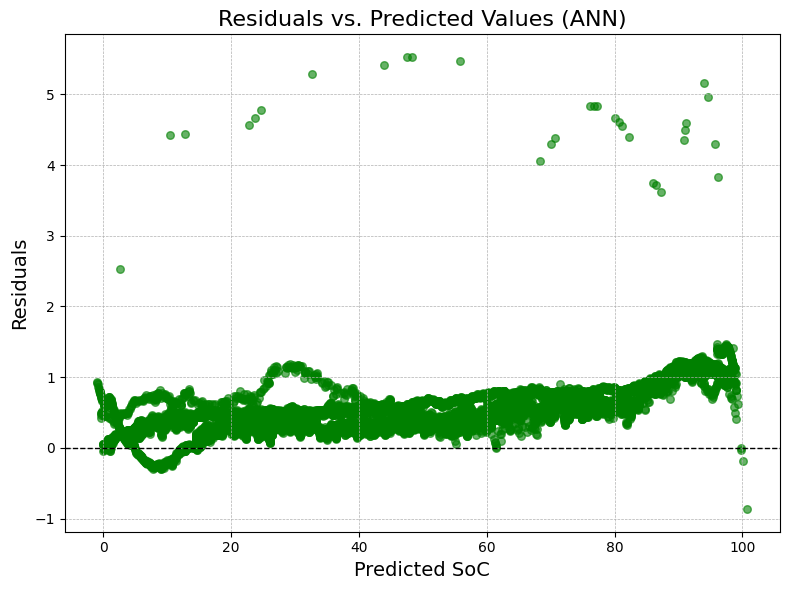

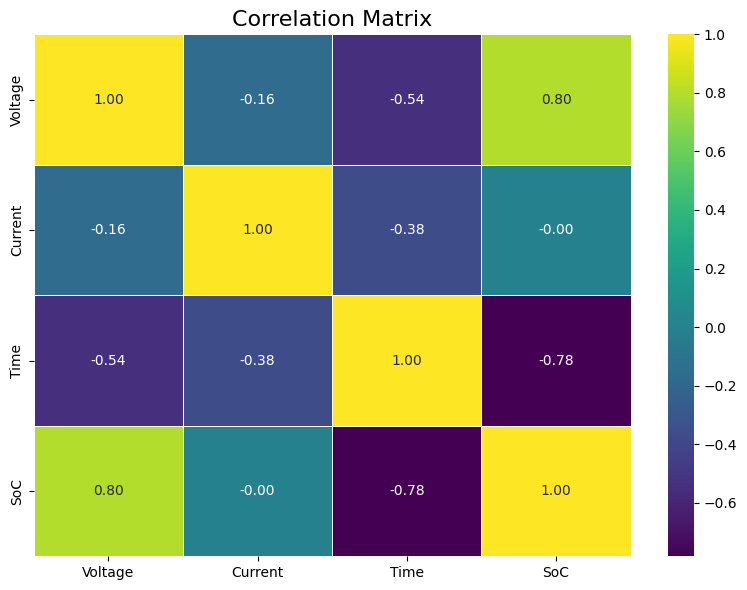

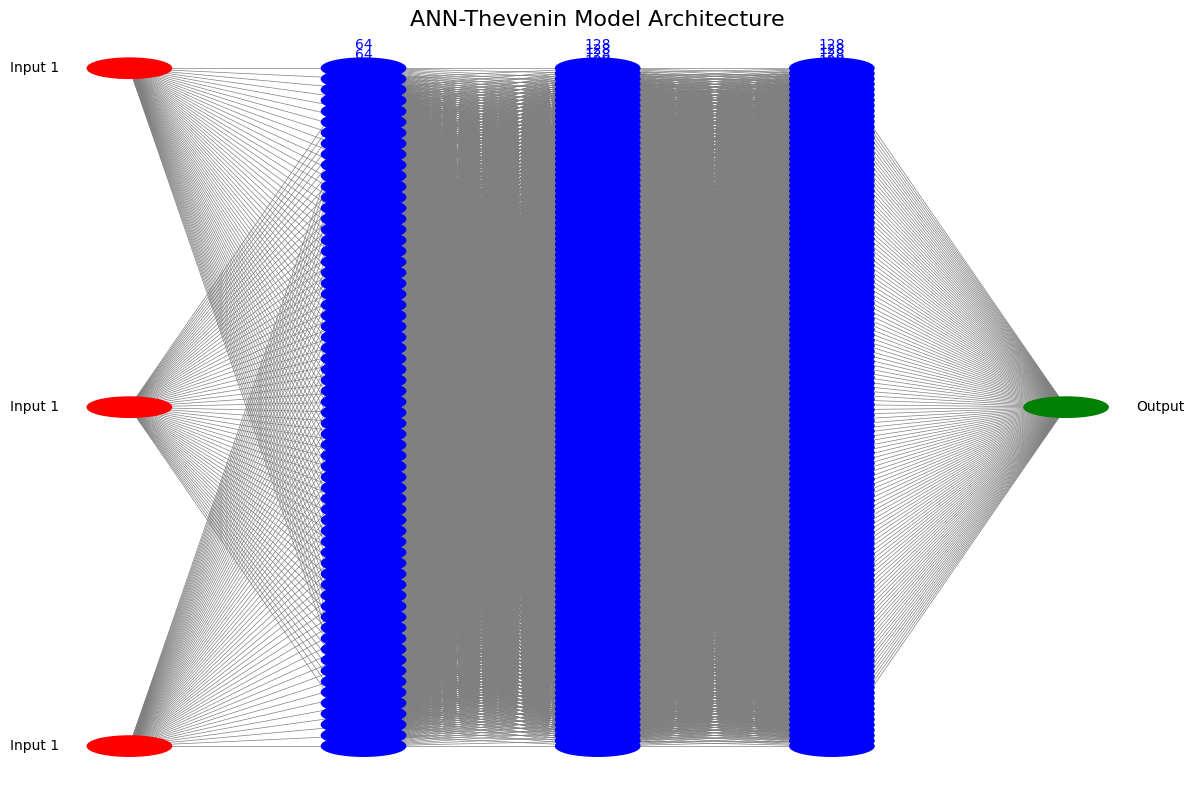

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score
import tensorflow as tf
import pickle

# Ensure plots are displayed within the notebook
%matplotlib inline

def smape(y_true, y_pred):
    return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

# Load and preprocess data
data = pd.read_csv('/content/battery_text.csv')
data = data.dropna()

features = ['Voltage', 'Current', 'Time']
target = 'SoC'
X = data[features]
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=16, shuffle=True)

# Normalize features
scaler_X = StandardScaler()  # Define scaler_X
X_train_scaled = scaler_X.fit_transform(X_train)  # Fit scaler_X to the training data
X_test_scaled = scaler_X.transform(X_test)

# Save the scaler
with open('scaler_X.pkl', 'wb') as f:
    pickle.dump(scaler_X, f)

# Define and train the ANN model
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train_scaled.shape[1],)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(1)  # Output layer for SoC prediction
])

model.compile(optimizer='adam', loss='mse')
model.fit(X_train_scaled, y_train, epochs=100, batch_size=32, verbose=1)
y_pred_ann = model.predict(X_test_scaled)
y_pred_ann = y_pred_ann.flatten()  # Flatten to 1D array
model.save('hybrid_ann_thevenin_model.keras')  # Add the .keras extension

# Evaluate the ANN model
mae_ann = mean_absolute_error(y_test, y_pred_ann)
r2_ann = r2_score(y_test, y_pred_ann)
smape_ann = smape(y_test, y_pred_ann)

print(f"ANN Model: MAE: {mae_ann:.4f}, R²: {r2_ann:.4f}, SMAPE: {smape_ann:.4f}%")

# ============================
# Matplotlib Visualizations
# ============================

# 1. Actual vs Predicted SoC (ANN)
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred_ann, color='blue', s=30, label='Predicted SoC')
# Perfect prediction line
min_val = min(y_test.min(), y_pred_ann.min())
max_val = max(y_test.max(), y_pred_ann.max())
plt.plot([min_val, max_val], [min_val, max_val], 'k--', label='Perfect Prediction')
# Annotation for SMAPE
plt.text(min_val + 0.6*(max_val - min_val), max_val - 0.1*(max_val - min_val),
         f"Error: {smape_ann:.2f}%", fontsize=12, color='black')
plt.title("Actual vs Predicted SoC (ANN)", fontsize=16)
plt.xlabel("Actual SoC", fontsize=14)
plt.ylabel("Predicted SoC", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()

# 2. Distribution of Errors (Histogram)
error_dist = y_test - y_pred_ann.flatten()
plt.figure(figsize=(8, 6))
sns.histplot(error_dist, bins=30, kde=True, color='orange', edgecolor='black', alpha=0.7)
plt.title("Distribution of Errors (ANN)", fontsize=16)
plt.xlabel("Error", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.grid(True, linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 3. Residuals vs. Predicted Values
plt.figure(figsize=(8, 6))
plt.scatter(y_pred_ann.flatten(), error_dist, color='green', s=30, alpha=0.6)
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.title("Residuals vs. Predicted Values (ANN)", fontsize=16)
plt.xlabel("Predicted SoC", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# 4. Correlation Matrix (Voltage, Current, Time, SoC)
corr_matrix = data[['Voltage', 'Current', 'Time', 'SoC']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='viridis', linewidths=0.5)
plt.title("Correlation Matrix", fontsize=16)
plt.tight_layout()
plt.show()

# 5. Neural Network Diagram
def plot_ann_matplotlib():
    layer_sizes = [3, 64, 128, 128, 1]  # Input layer (3), Hidden layers (64, 128, 128), Output layer (1)
    num_layers = len(layer_sizes)

    # Define spacing
    horizontal_spacing = 1 / (num_layers + 1)
    layer_positions = [horizontal_spacing * (i + 1) for i in range(num_layers)]

    plt.figure(figsize=(12, 8))
    ax = plt.gca()

    # Calculate max number of nodes for vertical spacing
    max_nodes = max(layer_sizes)

    # Store positions of nodes
    node_positions = []

    for i, (layer_size, x) in enumerate(zip(layer_sizes, layer_positions)):
        # Evenly distribute nodes vertically
        if layer_size > 1:
            y = np.linspace(-1, 1, layer_size)
        else:
            y = [0]
        node_positions.append([(x, yi) for yi in y])
        for (xi, yi) in node_positions[-1]:
            if i == 0:
                color = 'red'  # Input layer
            elif i == num_layers -1:
                color = 'green'  # Output layer
            else:
                color = 'blue'  # Hidden layers
            circle = plt.Circle((xi, yi), 0.03, color=color, zorder=4)
            ax.add_artist(circle)
            # Optionally, add layer labels
            if i == 0:
                plt.text(xi - 0.05, yi, f'Input {i+1}', ha='right', va='center', fontsize=10)
            elif i == num_layers -1:
                plt.text(xi + 0.05, yi, f'Output', ha='left', va='center', fontsize=10)
            else:
                plt.text(xi, yi + 0.07, f'{layer_size}', ha='center', va='center', fontsize=10, color='blue')

    # Draw connections
    for i in range(1, num_layers):
        for (x0, y0) in node_positions[i-1]:
            for (x1, y1) in node_positions[i]:
                plt.plot([x0, x1], [y0, y1], color='gray', linewidth=0.5, zorder=1)

    plt.title("ANN-Thevenin Model Architecture", fontsize=16)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# Call the function to plot the ANN architecture
plot_ann_matplotlib()





In [2]:
# ============================
# Model Saving and Prediction
# ============================

import pandas as pd
import numpy as np
import tensorflow as tf
import pickle

# Load the scaler for input features (you must save the scaler during training)
def load_scaler(filename):
    with open(filename, 'rb') as f:
        scaler = pickle.load(f)
    return scaler
# Load the hybrid ANN-Thevenin model from the saved .keras file
def load_hybrid_model(filename):
    hybrid_model = tf.keras.models.load_model(filename)
    return hybrid_model

# Function to make a prediction using predefined Voltage, Current, and Time values
def predict_soc(hybrid_model, scaler, voltage, current, time):
    # Prepare the input array as a DataFrame with feature names
    input_data = pd.DataFrame([[voltage, current, time]], columns=['Voltage', 'Current', 'Time'])

    # Scale the input data using the scaler from training
    input_data_scaled = scaler.transform(input_data)

    # Make prediction using the hybrid model
    predicted_soc = hybrid_model.predict(input_data_scaled)
    return predicted_soc[0][0]  # Extract the prediction from the nested array

In [3]:
# Load the saved hybrid ANN-Thevenin model (.keras file)
model_filename = 'hybrid_ann_thevenin_model.keras'
hybrid_model = load_hybrid_model(model_filename)

# Load the saved scaler used during training
scaler_filename = 'scaler_X.pkl'
scaler = load_scaler(scaler_filename)

# Define your input values here
voltage = 16.9    # Example Voltage in volts
current = 1.0     # Example Current in amps
time = 1.0        # Example Time in seconds

# Make the prediction
predicted_soc = predict_soc(hybrid_model, scaler, voltage, current, time)
print(f"Predicted SoC: {predicted_soc:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted SoC: 100.7793
